In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from connectomics.model import build_model
from model import build_madi_model
from connectomics.config.defaults import get_cfg_defaults

import numpy as np
import matplotlib.pyplot as plt

In [10]:
cfg = get_cfg_defaults()
cfg.merge_from_file('config.yaml')

In [ ]:
import torch
model = build_madi_model(cfg, torch.device('cpu'), None)

In [5]:
model

Unet3D(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False, padding_mode=replicate)
    (bn1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (relu): ELU(alpha=1.0, inplace=True)
    (layer0): Sequential(
      (0): InvertedResidual(
        (layers1): Sequential(
          (0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (2): ELU(alpha=1.0, inplace=True)
          (3): Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), groups=32, bias=False, padding_mode=replicate)
          (4): GroupNorm(8, 32, eps=1e-05, affine=True)
          (5): ELU(alpha=1.0, inplace=True)
        )
        (layers2): Sequential(
          (0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (1): GroupNorm(8, 32, eps=1e-05, affine=True)
        )
        (attention): SELayer3d(
         

In [6]:
model.cuda()
# with torch.no_grad():
%time print(model(torch.randn(1,1,114,320,320).cuda()).shape)

torch.Size([1, 3, 114, 320, 320])
CPU times: user 131 ms, sys: 70.5 ms, total: 201 ms
Wall time: 240 ms


In [5]:
# 64 -> 23849 MB mem usage
# 96 -> 31257 MB mem usage -> should fit on a100 with mixed prec

model.cuda()
opt = torch.optim.Adam(model.parameters())
L = torch.nn.MSELoss()

for _ in range(10):
    x,y = torch.randn(1,1,96,320,320).cuda(), torch.randn(1,1,96,320,320).cuda()
    p = model(x)
    l = L(p,y)
    print(l)
    
    opt.zero_grad()
    l.backward()
    opt.step()

/n/home11/abanerjee/.conda/envs/snemi_new/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 1, 96, 320, 320])) that is different to the input size (torch.Size([1, 3, 96, 320, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.7839, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(4.2457, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.9718, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5941, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6153, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5250, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3983, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2866, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2593, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2754, device='cuda:0', grad_fn=<MseLossBackward0>)


In [11]:
from train import MadiTrainer

t = MadiTrainer(cfg, 0)

Optimizer:  SGD
Channel split rule for prediction:  [3]
Channel split rule for prediction:  [3]


/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/abanerjee/UW_Madison/pytorch_connectomics/projects/UWMadison/train.py:100: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv('/n/home11/abanerjee/UW_Madison/data/train_set.csv', delimiter='; '),


Total number of samples to be generated:  0.0


/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/abanerjee/UW_Madison/pytorch_connectomics/projects/UWMadison/train.py:110: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv('/n/home11/abanerjee/UW_Madison/data/train_set.csv', delimiter='; '),


Total number of samples to be generated:  0.0


In [16]:
%time out = t.train_dataset[0]

CPU times: user 1.76 s, sys: 1.01 s, total: 2.77 s
Wall time: 1.9 s


In [12]:
%time out = t.train_dataset[0]

CPU times: user 601 ms, sys: 601 ms, total: 1.2 s
Wall time: 1.2 s


In [17]:
out[1].shape

(1, 96, 320, 320)

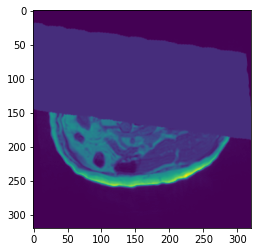

In [28]:
plt.imshow(out[1][0, 55])

In [12]:
out[2][0].shape

(3, 96, 320, 320)

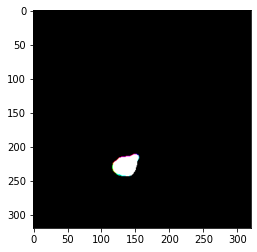

In [29]:
plt.imshow(out[2][0][:, 55].transpose(1,2,0))

In [30]:
out[2][0].dtype

[autoreload of train failed: Traceback (most recent call last):
  File "/n/home11/abanerjee/.conda/envs/snemi_new/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/n/home11/abanerjee/.conda/envs/snemi_new/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/n/home11/abanerjee/.conda/envs/snemi_new/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/abanerjee/UW_Madison/pytorch_connectomics/projects/UWMadison/train.py", line 26, in <module>
    import Albumentations as A
ModuleNotFoundError: No module named 'Albument

dtype('float32')

In [24]:
np.unique(np.where(out[2][0]>0)[1])

array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71])

In [16]:
np.unique(out[2][1])

IndexError: list index out of range

In [11]:
import numpy as np
np.unique(out[1])

array([-0.1792], dtype=float32)